# Tarea
# Alumno:  Isaias Tenorio

1.   Modificar los parámetros :  Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.
2.   Implementar embedding posicional aprendido 1D : Partiendo del ejemplo proporcionado ( codificación sinusoidal en clase PositionalEncoding) , implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. graficar.



Importamos las librerias necesarias para la elavoración del proyecto

In [3]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import math

Configuración , carga y preprocesamiento

In [4]:
# Defino una clase llamada ConfigPreprocess
class ConfigPreprocess:
   # Método constructor _init_
   def __init__(self, img_path: str, image_size: int , patch_size:int):
       # Configuración del dispositivo
       self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
       print(f'Dispositivo utilizado: {self.device}')
       # Asignación de atributos
       self.img_path = img_path
       self.image_size = image_size
       self.patch_size = patch_size
       # Carga de la imagen
       self.test_img = self.load_image()

   def load_image(self):
       return TF.to_tensor(Image.open(self.img_path).resize((self.image_size, self.image_size))).unsqueeze(0).to(self.device)

   # Función para dividir la imagen en parches más pequeños
   def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches

In [5]:
# Definición de la clase llamada PatchEmbedding que hereda de nn.Module
class PatchEmbedding(nn.Module):
    # Constructor de la clase PatchEmbedding , inicializa los parámetros
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        # LLamamos al constructor de la clase padre nn.Module
        super(PatchEmbedding, self).__init__()
        # Almacena el tamaño de la imagen
        self.img_size = img_size
        # Almacena el tamaño de cada parche
        self.patch_size = patch_size
        # Almacena el número total de parches de cada imagen
        self.num_patches = (img_size // patch_size) ** 2
        # Creamos una capa convolucional para convertir parches en vectores de características
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    # Creamos el método forward , procesa la entrada x
    def forward(self, x):
        # Aplica la capa convolucional a la entrada
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        # Aplanamos la salida en dos dimensiones
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        # Cambiamos el orden de las dimensiones
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        # Retorna la salida procesada
        return x

In [6]:
# Definimos la clase PositionalEncoding que hereda de nn.Module
class PositionalEncoding(nn.Module):
    # Definimos el constructor de la clase, inicializa los parámetros
    def __init__(self, num_patches, embed_dim):
        # Llamamos al constructor de la clase padre
        super(PositionalEncoding, self).__init__()
        # Registra el tensor de posición como buffer en el módulo
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    # Creamos el método de codificación positional
    def create_positional_encoding(self, num_patches, embed_dim):
        # Creamos un tensor con índices de posición desde 0 hasta números de patches
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        # Creamos el término de división para la fórmula de codificación positional
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        # Inicializa el tensor de codificación positional con ceros
        pos_encoding = torch.zeros(num_patches, embed_dim)
        # Aplicamos la función seno en las dimensiones pares de la codificación positional
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        # Aplicamos la función coseno en las dimensiones impares de la codificación positional
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    # Creamos el método Forward , suma la codificación positional a la entrada
    def forward(self, x):
        # Retorna la suma de la entrada y la codificación positional
        return x + self.pos_embedding

In [7]:
# Definición de la clase Visualization
class Visualization:
    # Método estático para visualizar parches de imágenes
    @staticmethod  # No requiere self
    def visualize_patches(patches: Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches ** 0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout(pad=0.15)
        plt.show()

    # Método estático para visualizar codificaciones posicionales
    @staticmethod  # No requiere self
    def visualize_positional_encoding(pos_embeddings: Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales para los Parches', fontsize=16, weight='bold')
        for i in range(pos_embeddings.shape[2]):
            plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i + 1}')
        plt.xlabel('Índice del Parche', fontsize=14)
        plt.ylabel('Valor de la Codificación Posicional', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    # Método estático para visualizar la codificación de un parche específico
    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: Tensor, patch_idx: int):
        num_patches = pos_embeddings.shape[1]
        if patch_idx < 0 or patch_idx >= num_patches:
            raise ValueError(f"El índice del parche debe estar entre 0 y {num_patches - 1}, pero se recibió {patch_idx}.")
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker='o', label=f'Parche {patch_idx + 1}')
        plt.title(f'Encoding Posicional para el Parche {patch_idx + 1}', fontsize=16, weight='bold')
        plt.xlabel('Dimensión del Embedding', fontsize=14)
        plt.ylabel('Valor del Encoding', fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()

Dispositivo utilizado: cpu


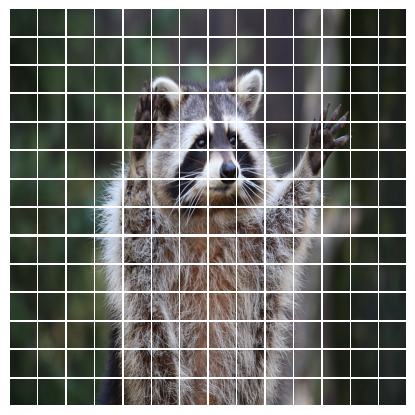

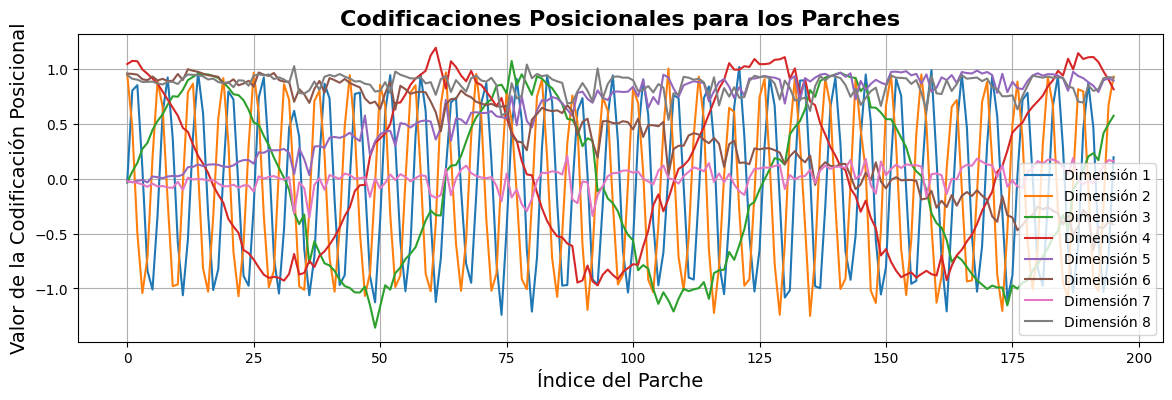

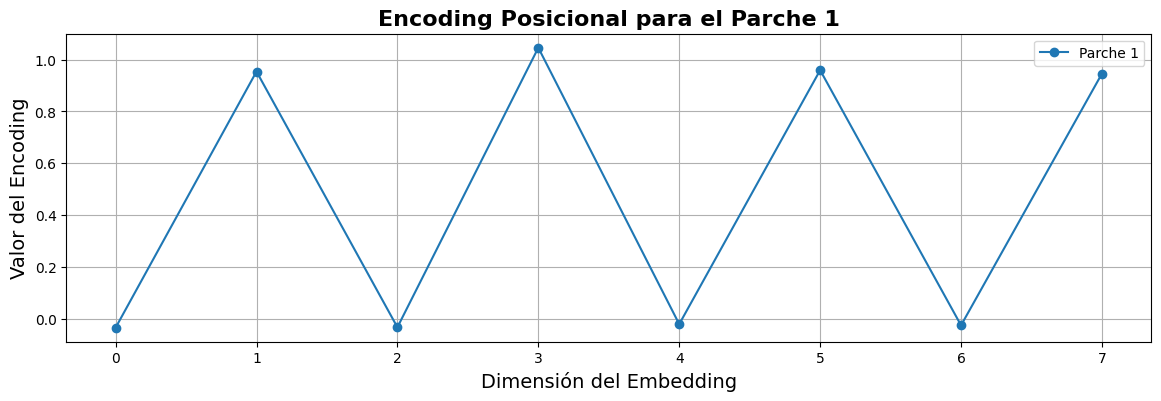

In [8]:
# Parámetros
img_path = "raccoon.jpg"
image_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path,image_size,patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(image_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (image_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

# 1.   Modificar los parámetros :  Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.

**Combinaciones de valores para experimentar**

1.1) patch_size=16, embed_dim=8

 Captura detalles finos en los parches con una codificación simple.

Dispositivo utilizado: cpu


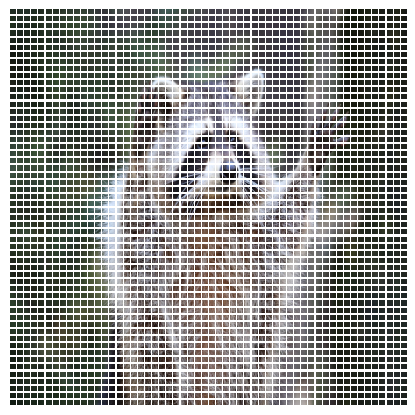

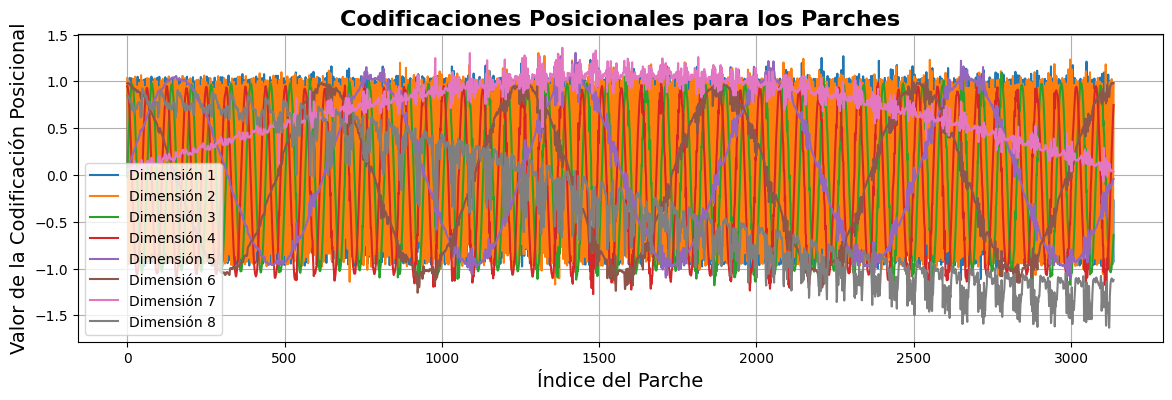

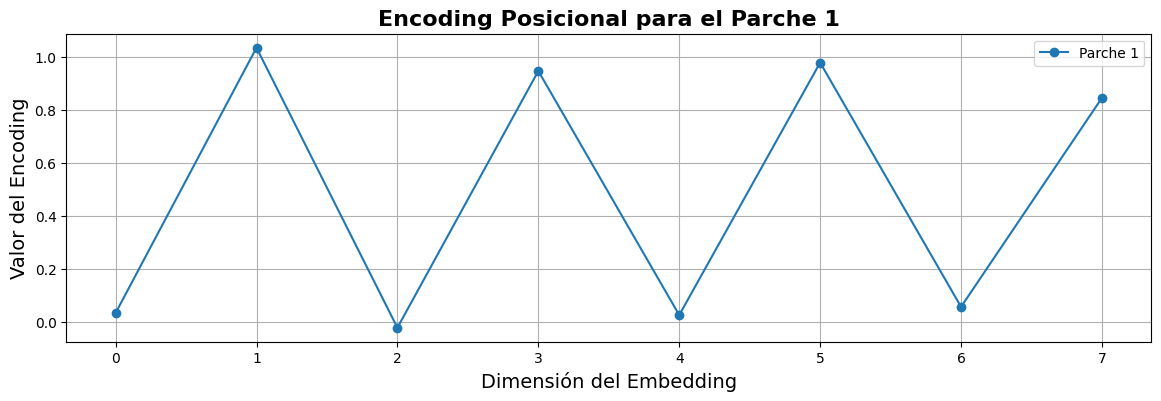

In [9]:
# Parámetros
img_path = "raccoon.jpg"
image_size = 900
patch_size = 16
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path,image_size,patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(image_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (image_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

Ventajas

1.   Captura de detalles finos en la imagen.
2.   Menor complejidad computacional y uso de memoria.
3.   Representación simple y ligera en cada parche.

Desventajas

1.   Capacidad limitada para representar patrones complejos.
2.   Mayor cantidad de parches incrementa la carga de procesamiento.
3.   Dificultad para capturar relaciones globales en la imagen.



1.2) patch_size=32, embed_dim=16

Captará detalles moderados, con un embedding pequeño para evaluar rápidamente.

Dispositivo utilizado: cpu


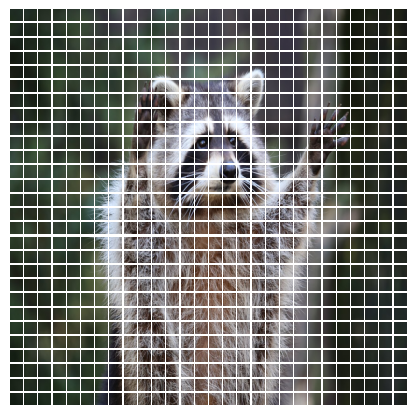

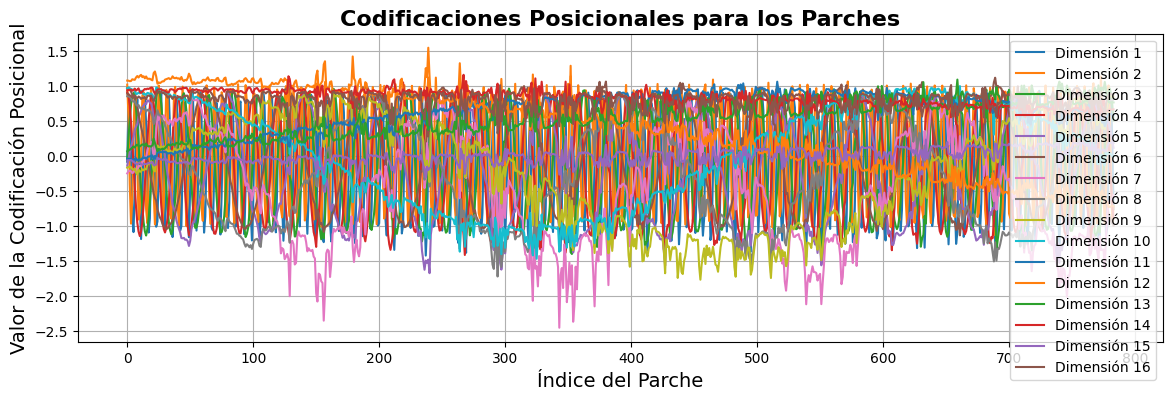

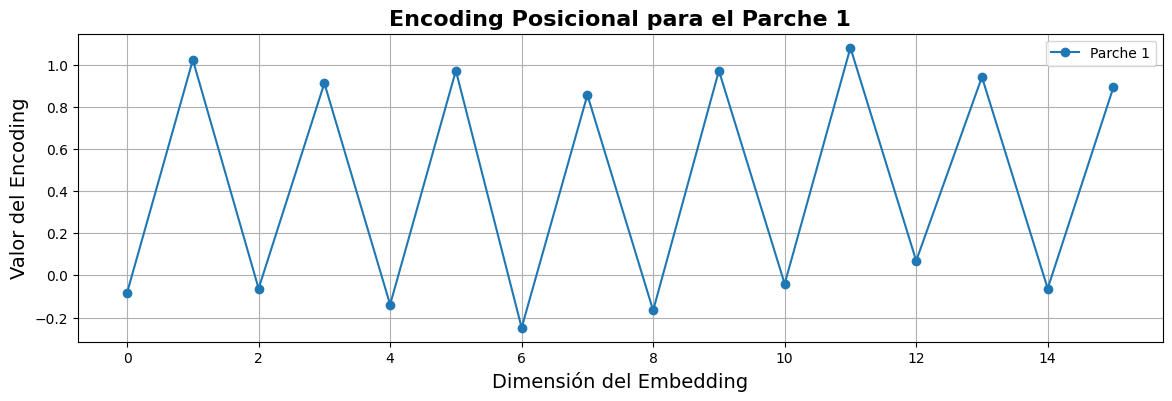

In [10]:
# Parámetros
img_path = "raccoon.jpg"
image_size = 900
patch_size = 32
embed_dim = 16
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path,image_size,patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(image_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (image_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

Ventajas:

1. Balance entre detalles locales y globales de la imagen.
2. Mayor capacidad de representación para patrones complejos.
3.Reducción de la cantidad de parches, optimizando el procesamiento.

Desventajas:
1. Mayor carga computacional y uso de memoria.
2. Menor capacidad para capturar detalles muy finos.
3. Embeddings más grandes pueden ser excesivos para tareas simples.

1.3 ) patch_size=64, embed_dim=32

Buen balance para tareas generales, manteniendo un costo computacional moderado.

Dispositivo utilizado: cpu


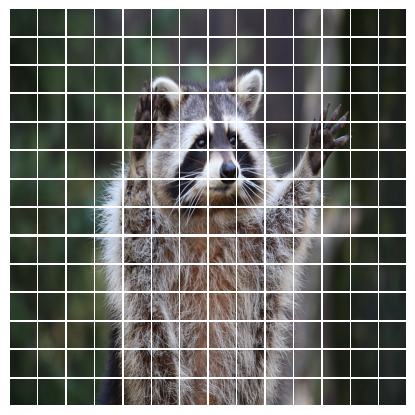

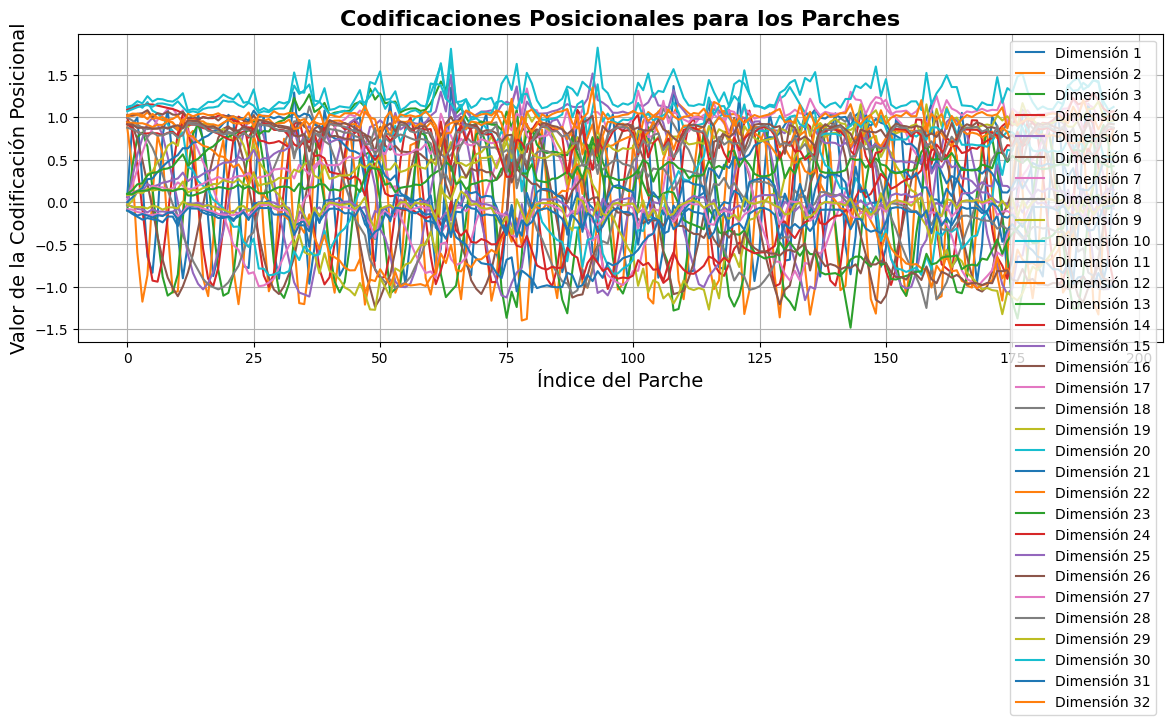

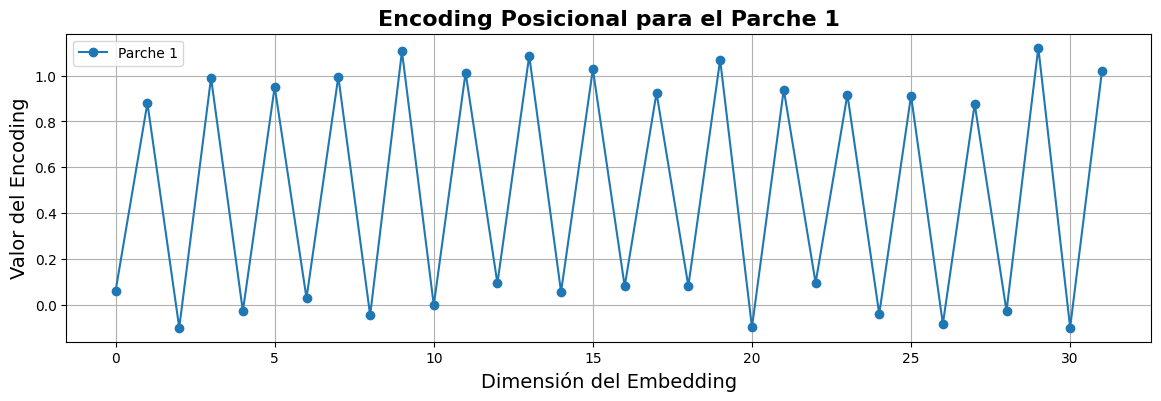

In [11]:
# Parámetros
img_path = "raccoon.jpg"
image_size = 900
patch_size = 64
embed_dim = 32
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path,image_size,patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(image_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (image_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

Ventajas:

1. Captura efectiva de características globales y estructura general de la imagen.
2. Menor cantidad de parches, reduciendo la carga de procesamiento.
3. Alta capacidad de representación en cada parche, útil para patrones complejos.

Desventajas:

1. Menos capacidad para capturar detalles locales y finos.
2. Mayor demanda de memoria y cómputo por parche.
3. Menos flexibilidad en la representación de variaciones locales.

1.4 ) patch_size=16, embed_dim=32

Muchos parches con un embedding rico para capturar detalles complejos.

Dispositivo utilizado: cpu


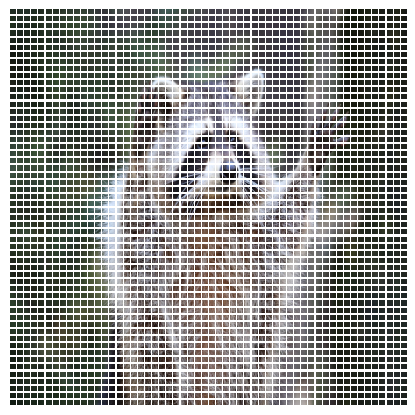

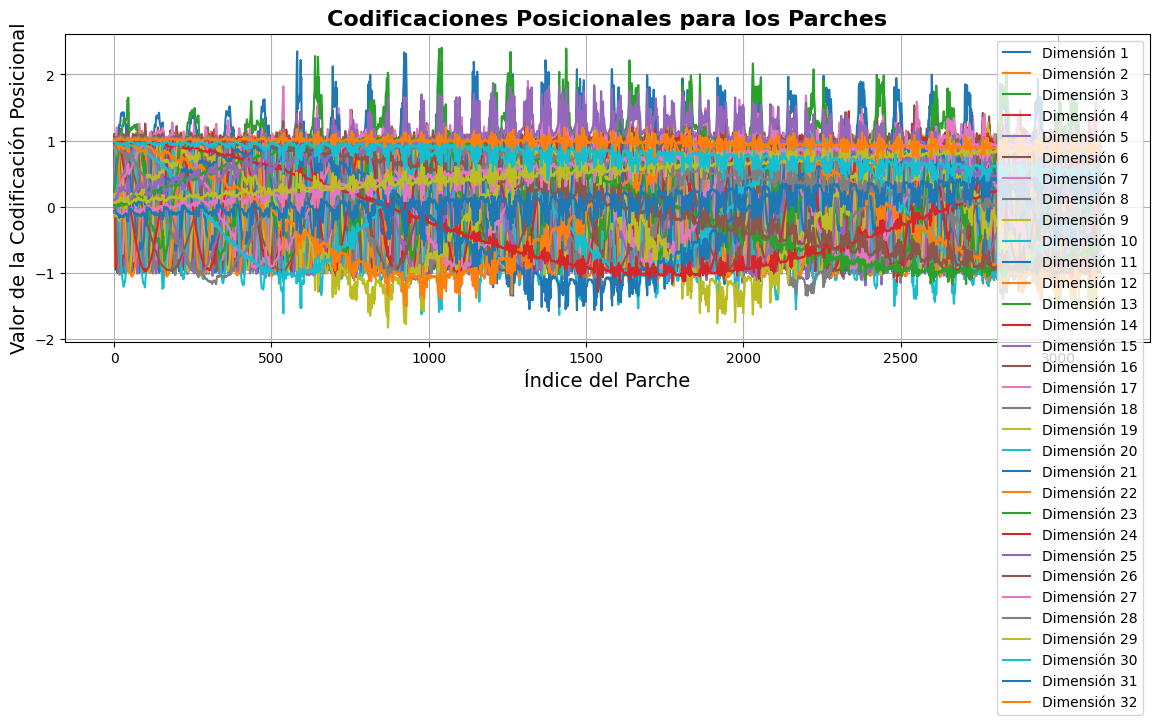

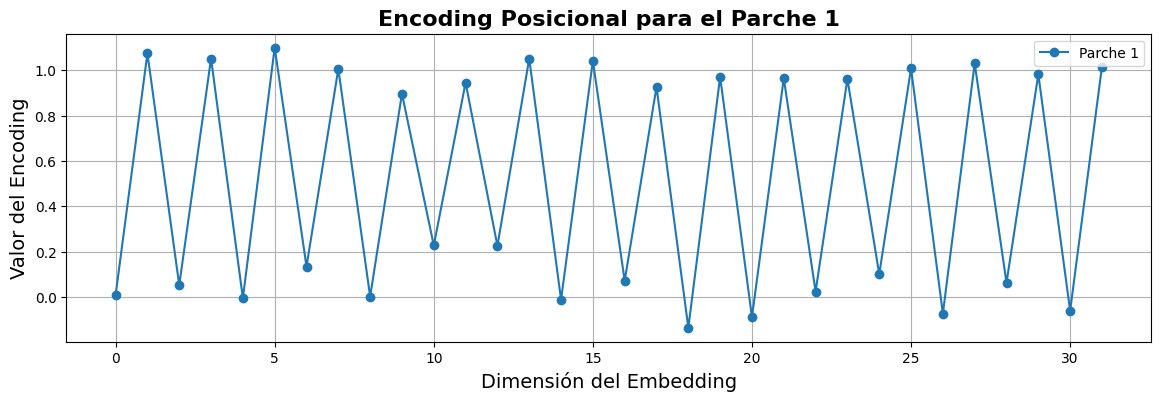

In [12]:
# Parámetros
img_path = "raccoon.jpg"
image_size = 900
patch_size = 16
embed_dim = 32
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path,image_size,patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(image_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (image_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

Ventajas:

1. Captura tanto de detalles finos como de patrones complejos.
2. Alta capacidad de representación en cada parche.
3. Flexibilidad en la detección de variaciones locales detalladas.

Desventajas:

1. Alta carga computacional y demanda de memoria.
2. Incremento significativo en el número de parches a procesar.
3. Mayor complejidad en el modelo, que podría ser excesiva para algunas tareas.

1.5 ) patch_size=64, embed_dim=8

Parche grande con una codificación sencilla, buena para información de alto nivel.

Dispositivo utilizado: cpu


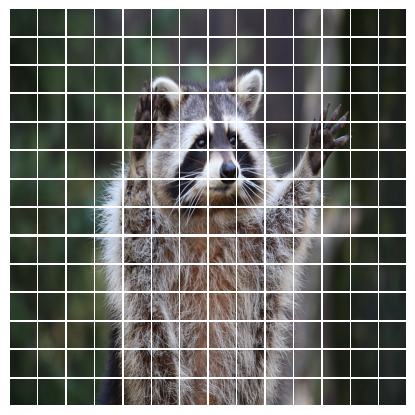

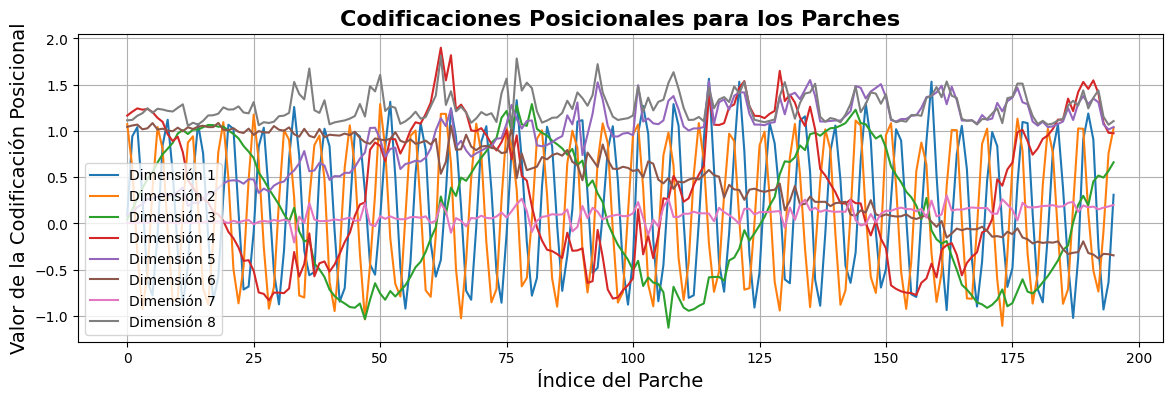

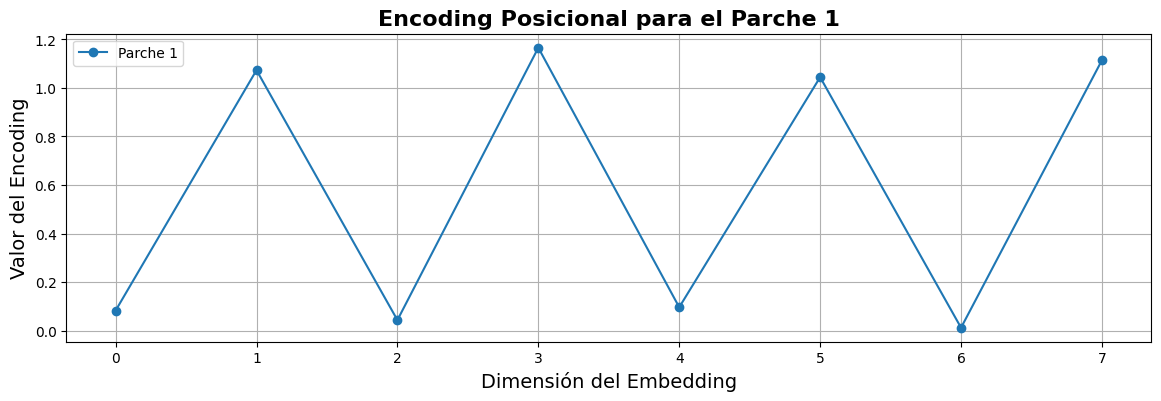

In [13]:
# Parámetros
img_path = "raccoon.jpg"
image_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path,image_size,patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(image_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (image_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

Ventajas:

1. Captura de características globales y estructura general de la imagen.
2. Menor carga computacional debido a la reducción en la cantidad de parches.
3. Representaciones más simples que pueden ser suficientes para tareas menos complejas.

Desventajas:

1. Pérdida de detalles finos y variaciones locales importantes.
2. Limitada capacidad para representar patrones complejos.
3. Posible subrepresentación de características relevantes en la imagen.

1.6) patch_size=128 , embed_dim=128

Captura información global con un embedding alto para tareas que requieran precisión a nivel de patrones generales.

Dispositivo utilizado: cpu


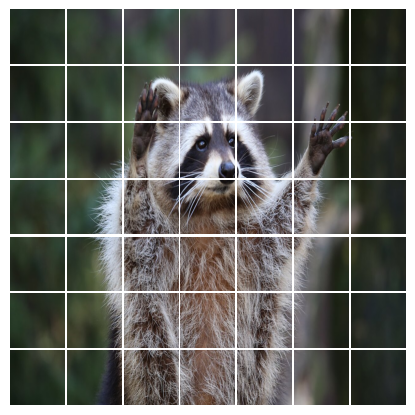

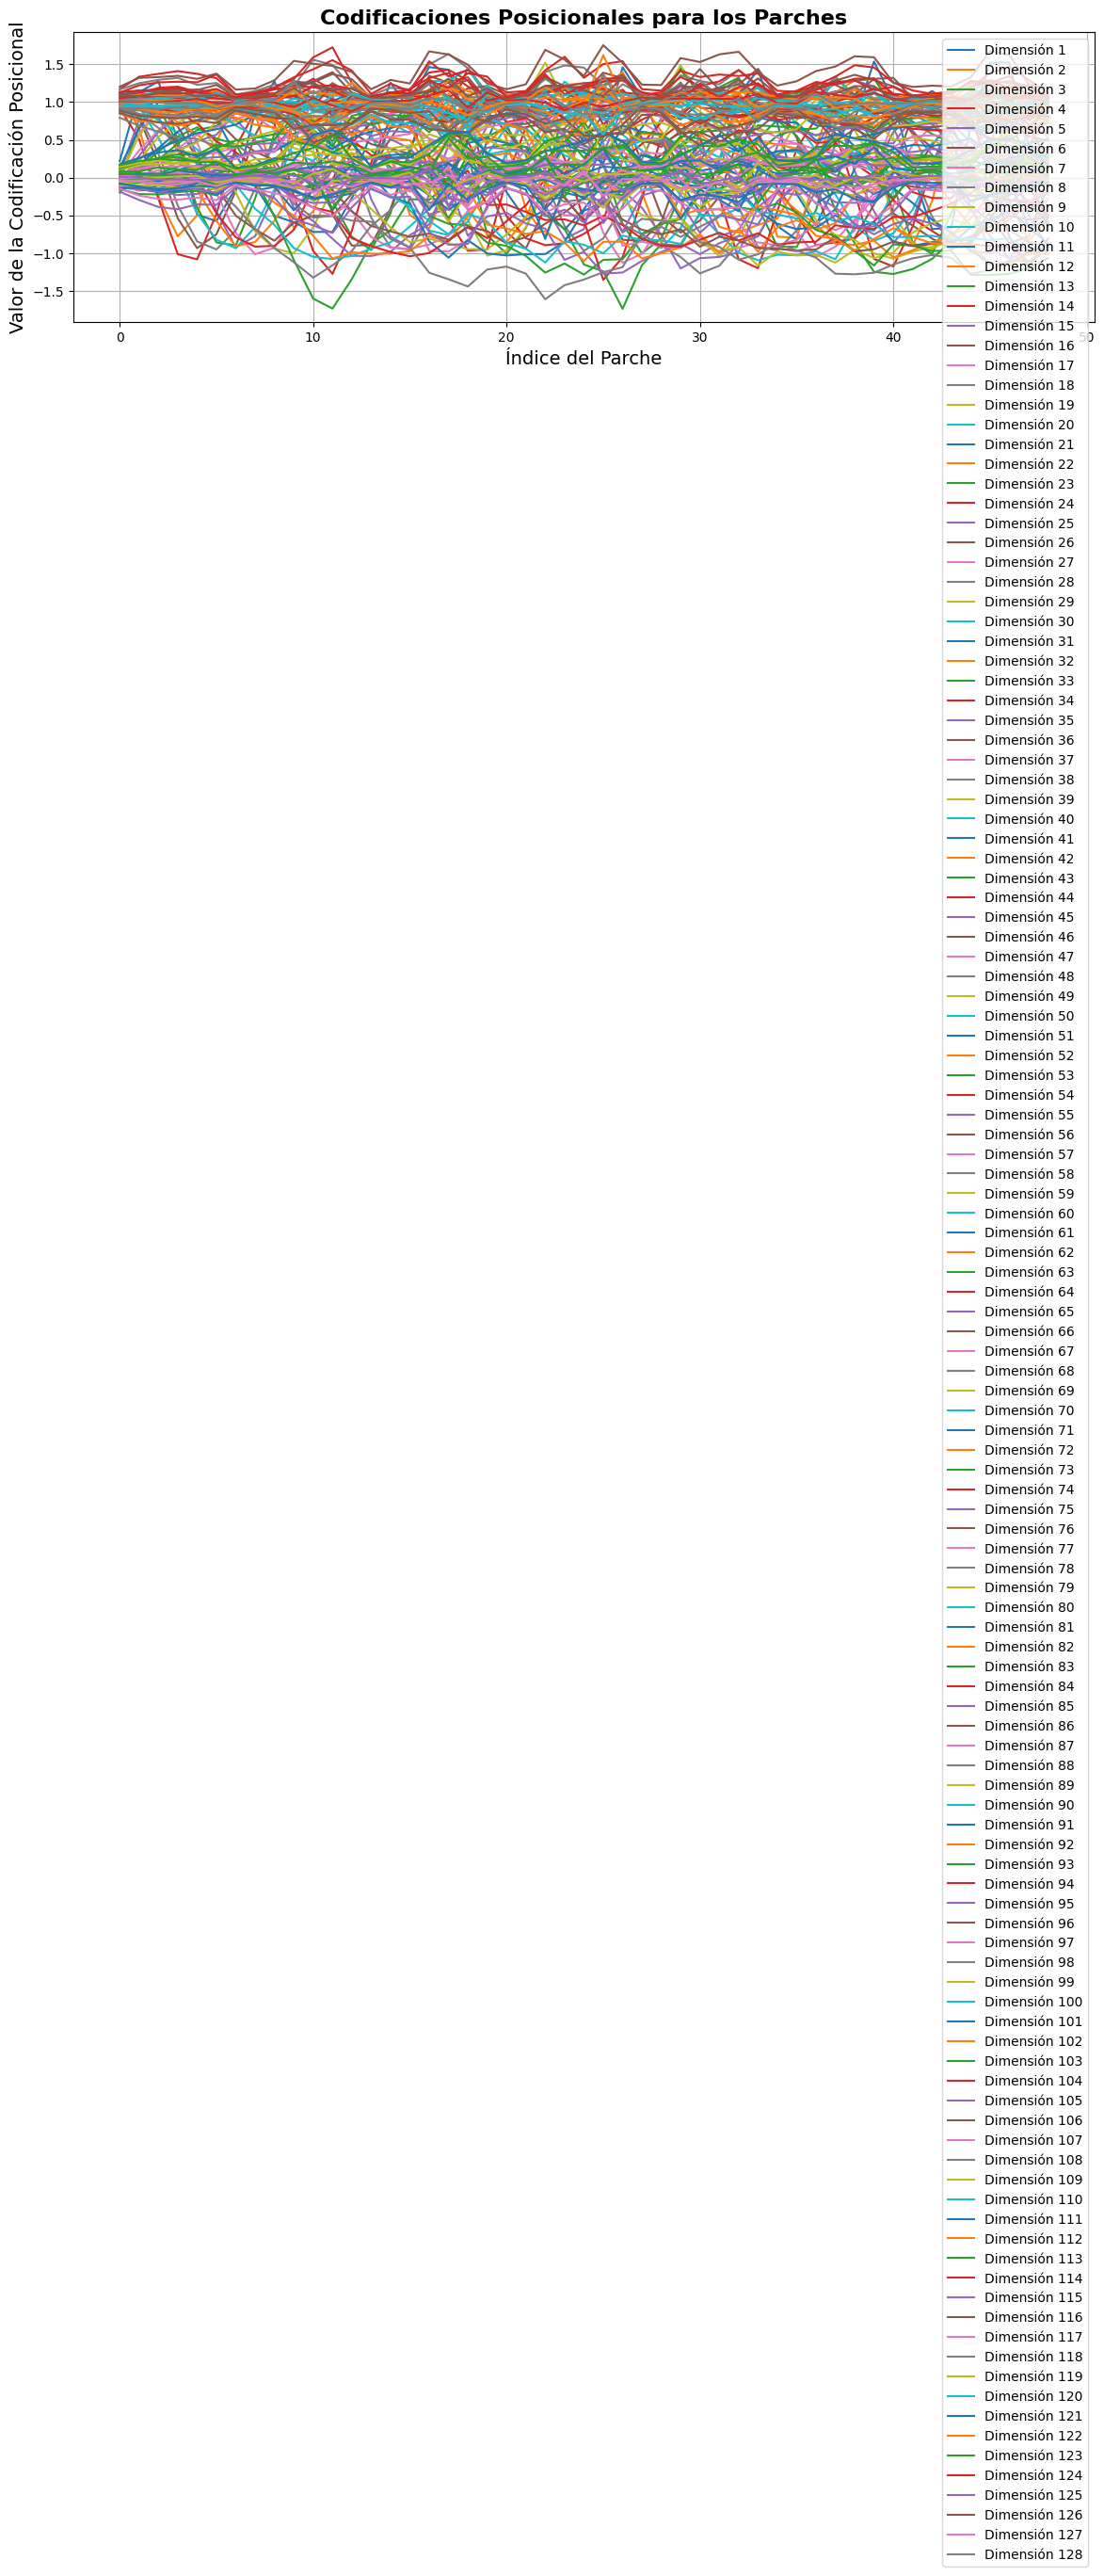

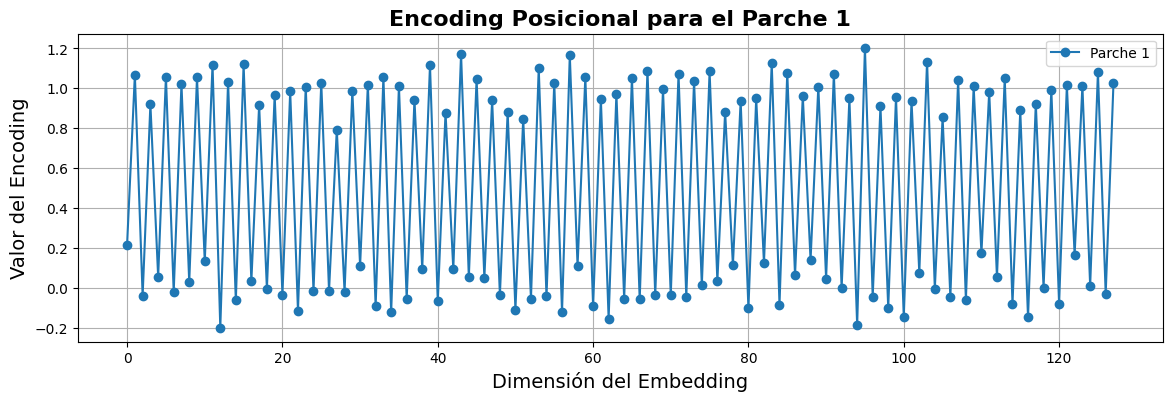

In [14]:
# Parámetros
img_path = "raccoon.jpg"
image_size = 900
patch_size = 128
embed_dim = 128
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path,image_size,patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(image_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (image_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

**Ventajas**

1.   Captura información global : Ideal para patrones amplios en la imagen.
2.   Menos parches : Menor carga de procesamiento, ya que se dividen en menos parches.
3. Alta capacidad de representación : embed_dim=128 permite captar patrones complejos en cada parche.

**Desventajas**


1.   Pérdida de detalles finos: Parche grande puede omitir texturas pequeñas.
2.   Mayor carga computacional por parche: La alta dimensionalidad exige más memoria.
3. Riesgo de sobreajuste : embed_dim=128 puede sobreajustarse en tareas simples o datos limitados.


# 2) Implementar embedding posicional aprendido 1D : Partiendo del ejemplo proporcionado ( codificación sinusoidal en clase PositionalEncoding) , implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. graficar.

**Implementación de la clase PositionalEncodingLearned**

In [15]:
# Creamos una clase llamada PositionalEncodingLearned
class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        # Creamos una capa de embedding para el encoding posicional
        self.pos_embedding = nn.Embedding(num_patches, embed_dim)

        # Inicializamos los índices de posición de 0 a num_patches - 1
        self.position_ids = torch.arange(0, num_patches).unsqueeze(0)

    def forward(self, x):
        # Sumamos el embedding posicional a los embeddings de los parches
        position_ids = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        pos_embeddings = self.pos_embedding(position_ids)
        return x + pos_embeddings

# Cálculo de la cantidad de parches
num_patches = (image_size // patch_size) ** 2

# Ahora creamos el PositionalEncodingLearned
positional_encoding_learned = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
learned_pos_embeddings = positional_encoding_learned(patches)

Visualización de los Embeddings Posicionales Aprendidos

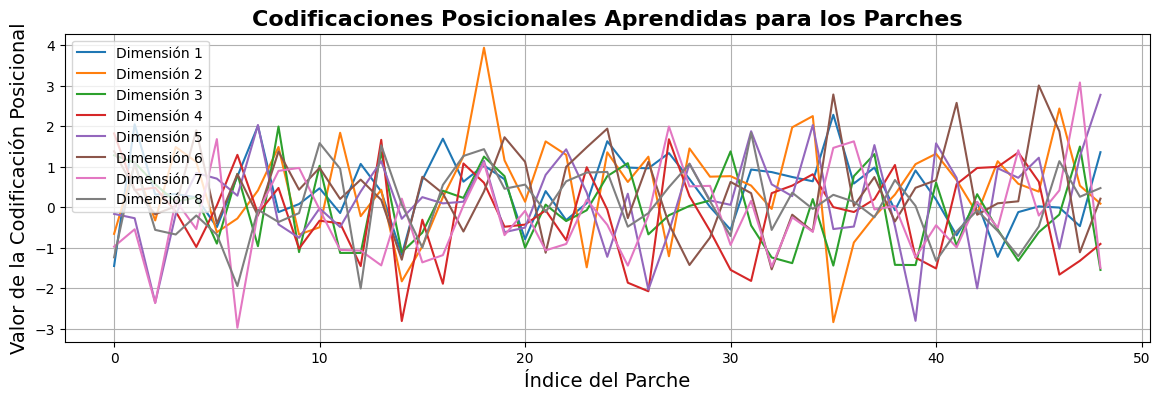

In [17]:
# Visualización de los embeddings posicionales aprendidos
num_dims_to_plot = 8
plt.figure(figsize=(14, 4))
plt.title('Codificaciones Posicionales Aprendidas para los Parches', fontsize=16, weight='bold')
for i in range(min(num_dims_to_plot, learned_pos_embeddings.shape[2])):
    plt.plot(learned_pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i + 1}')
plt.xlabel('Índice del Parche', fontsize=14)
plt.ylabel('Valor de la Codificación Posicional', fontsize=14)
plt.legend()
plt.grid()
plt.show()

**conclusión**

La gráfica muestra las codificaciones posicionales aprendidas para los parches de una imagen a través de 8 dimensiones. Cada línea representa una dimensión del embedding, reflejando cómo el modelo ajusta las posiciones relativas de los parches durante el entrenamiento. La variabilidad entre dimensiones indica que el modelo está capturando patrones espaciales complejos, proporcionando una representación rica y adaptada a la estructura espacial de la imagen. Esta no linealidad permite que el modelo se ajuste mejor a variaciones espaciales en los datos, lo que podría mejorar el rendimiento en tareas que dependen de la disposición de los elementos en la imagen. En general, estas codificaciones posicionales aprendidas ofrecen al modelo una mayor flexibilidad y especificidad en su interpretación espacial.